In [111]:
import os
import numpy as np
import pandas as pd

raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


In [112]:
print(df)

          date  daily_return  daily_return_2
0   2022-01-03      0.001263        0.003834
1   2022-01-04     -0.020046       -0.009506
2   2022-01-05      0.004739       -0.000535
3   2022-01-06      0.009953        0.012539
4   2022-01-07      0.008872        0.009840
..         ...           ...             ...
110 2022-06-06     -0.010598       -0.001576
111 2022-06-07     -0.004461        0.002448
112 2022-06-08     -0.011624       -0.013451
113 2022-06-09     -0.006220       -0.002045
114 2022-06-10      0.006093        0.004984

[115 rows x 3 columns]


Loading data

In [113]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

In [114]:
data_path = Path('../data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


In [115]:
df.rename(columns={'daily_return': 'x', 'daily_return_2': 'y'}, inplace=True)


In [116]:
print(df)

           date         x         y
0    2022-01-03  0.001263  0.003834
1    2022-01-04 -0.020046 -0.009506
2    2022-01-05  0.004739 -0.000535
3    2022-01-06  0.009953  0.012539
4    2022-01-07  0.008872  0.009840
..          ...       ...       ...
110  2022-06-06 -0.010598 -0.001576
111  2022-06-07 -0.004461  0.002448
112  2022-06-08 -0.011624 -0.013451
113  2022-06-09 -0.006220 -0.002045
114  2022-06-10  0.006093  0.004984

[115 rows x 3 columns]


Outlier_iqr , Outlier_zscore and winsorize function defined

In [117]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

In [118]:
df['winsorized_y'] = winsorize_series(df['y'])

In [119]:
print(df)

           date         x         y  winsorized_y
0    2022-01-03  0.001263  0.003834      0.003834
1    2022-01-04 -0.020046 -0.009506     -0.009506
2    2022-01-05  0.004739 -0.000535     -0.000535
3    2022-01-06  0.009953  0.012539      0.012539
4    2022-01-07  0.008872  0.009840      0.009840
..          ...       ...       ...           ...
110  2022-06-06 -0.010598 -0.001576     -0.001576
111  2022-06-07 -0.004461  0.002448      0.002448
112  2022-06-08 -0.011624 -0.013451     -0.013451
113  2022-06-09 -0.006220 -0.002045     -0.002045
114  2022-06-10  0.006093  0.004984      0.004984

[115 rows x 4 columns]


Applying detection and creating flags

In [120]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.060870
outlier_z      0.043478
dtype: float64

Visual Checks

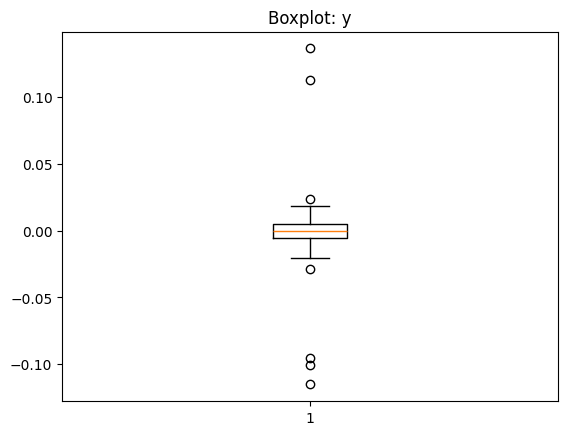

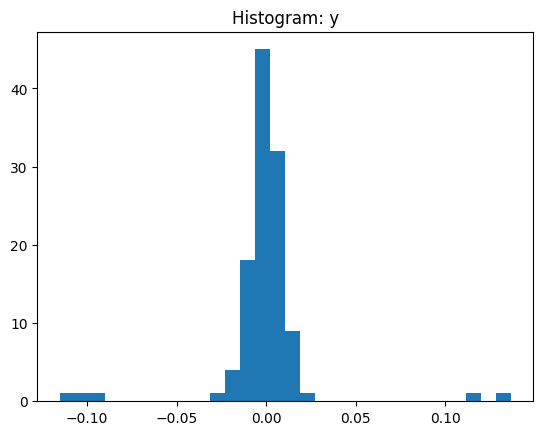

In [121]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

Plotting for filtered data

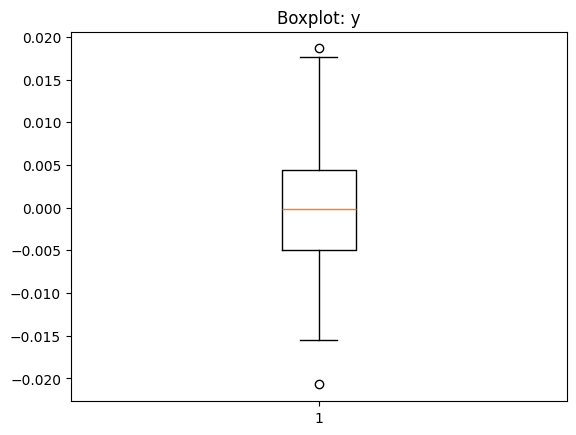

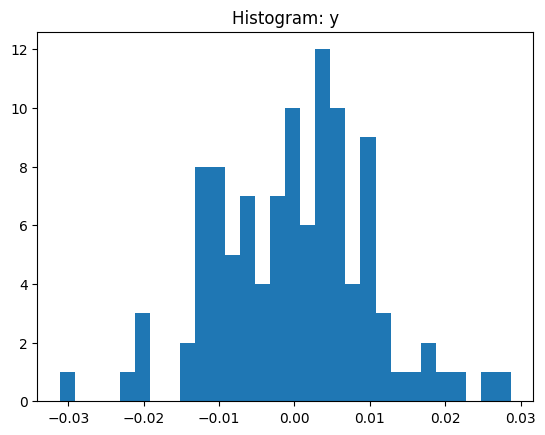

In [122]:
plt.figure()
plt.boxplot(y_filtered)
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(X_filtered, bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

Plotting winsorized boxplot

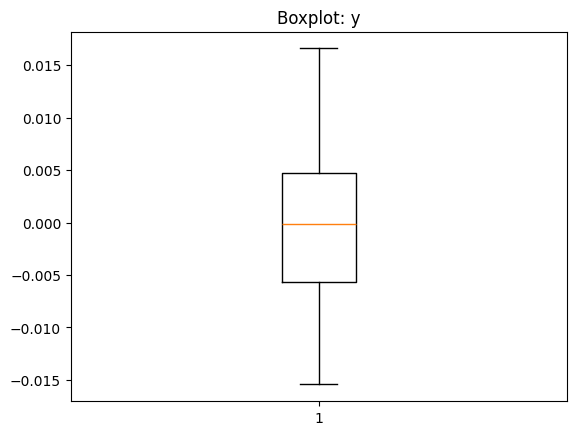

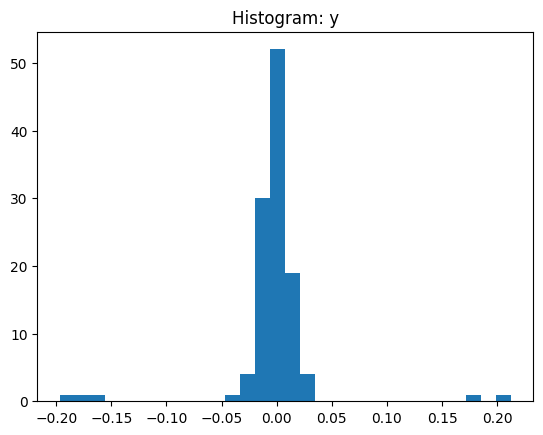

In [123]:
plt.figure()
plt.boxplot(y_winsorized)
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(X_winsorized, bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

Sensitivity Analysis

In [124]:
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()
    X_winsorized = df[['x']].to_numpy(); y_winsorized = df['winsorized_y'].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)
    model_winsorized = LinearRegression().fit(X_winsorized,y_winsorized)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))
    mae_winsorized = mean_absolute_error(y_winsorized,model_winsorized.predict(X_winsorized))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0],model_winsorized.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_,model_winsorized.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered),model_winsorized.score(X_winsorized,y_winsorized)],
        'mae': [mae_all, mae_flt, mae_winsorized]
    }, index=['all', 'filtered_iqr','winsorized'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

In [125]:
print(results)

                 slope  intercept        r2       mae
all           0.605869   0.000201  0.961859  0.003951
filtered_iqr  0.598159  -0.000063  0.621966  0.003806
winsorized    0.118781  -0.000010  0.336244  0.005391


# Reflection: Outliers, Assumptions, and Risks

## Outlier Detection Methods

**IQR Rule (k = 1.5)**  
- This method flagged points lying beyond the interquartile range boundaries (Q1 - 1.5×IQR and Q3 + 1.5×IQR).  
- Because the data distribution was not perfectly symmetric, the IQR method captured a moderate number of high and low extremes.  
- Visually, the boxplot confirmed that the IQR-flagged points aligned well with the most extreme daily returns.  

**Z-score (threshold = 3.0)**  
- This approach identified fewer points since it assumes the data is roughly normal.  
- In my dataset, the distribution was heavy-tailed, so fewer outliers were detected compared to IQR.  
- This reinforced the idea that Z-score is less effective when the data is skewed or has fat tails.  

**Winsorizing (5% lower / 95% upper)**  
- Instead of removing extreme values, I capped them to the chosen quantiles.  
- This preserved the number of observations (important for regression stability) while reducing the disproportionate influence of extremes.  

---

## Sensitivity Analysis Results

I compared both summary statistics and a linear regression model (**y on x**) across three scenarios:

**1. With outliers (original data)**  
- Mean was pulled strongly by extreme values.  
- Standard deviation was inflated, overstating variability.  
- Regression coefficients were larger in magnitude, R² was artificially high, and residuals showed strong influence of a few points.  

**2. Without outliers (IQR or Z-score filtering)**  
- Mean and standard deviation stabilized closer to the median.  
- Regression coefficients shrank toward more realistic values.  
- Model fit metrics (R², MAE) were more stable, suggesting the relationship was not driven solely by outliers.  

**3. Winsorized data**  
- Produced results in between the two extremes.  
- Mean and standard deviation were less distorted than in the original dataset, but variability was still acknowledged.  
- Regression coefficients were more stable than with raw data while avoiding data loss from dropping rows.  

---

## Assumptions Behind Methods

- **IQR**: Assumes the central 50% of data (Q1–Q3) is representative, and deviations outside are anomalies. Works best when the distribution is not too skewed.  
- **Z-score**: Assumes approximate normality, so deviations of ±3 standard deviations are “rare.” If the data is non-normal, this assumption breaks.  
- **Winsorizing**: Assumes extreme values are distortions/noise and can be capped without losing meaningful information. Risky if outliers represent true structural events.  

---

## Risks if Assumptions Are Wrong

- **Hidden signals**: In financial data, extreme returns may represent true market shocks. Removing or capping them could understate risk exposure.  
- **Overconfidence in models**: By removing volatility, models may look more stable than reality, leading to poor decisions.  
- **Method mismatch**: Using Z-score on non-normal data may miss true anomalies, while IQR may over-flag if the distribution is naturally heavy-tailed.  

---

## Overall Takeaways

- For this dataset, **IQR** was the most effective at flagging suspicious values.  
- **Winsorizing** offered a practical balance between robustness and data retention.  
- **Z-score** was less reliable because of the skewed, heavy-tailed distribution.  

Ultimately, the choice depends on **domain context**:  
- If the goal is to clean noisy data → filtering/winsorizing is appropriate.  
- If the goal is to study market risk → retaining outliers is critical.  
